# Detección de Fraudes en Transacciones Financieras

**Materia**: Herramientas para el Almacenamiento de Grandes Volúmenes  
**Estudiante**: Daniel Cureño Martínez  
**Semestre**: 5to  
**Fecha**: 24 de septiembre de 2025



## Objetivo
Identificar transacciones potencialmente fraudulentas aplicando reglas de negocio predefinidas, independientemente de la divisa.

In [1]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Confihuración estilos y opciones de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

## Carga de datos
Cargamos el archivo CSV con las transacciones simuladas y mostramos las primeras filas para verificar la estructura.

In [2]:
# Cargar el DataSet
df = pd.read_csv('transacciones_simuladas.csv')
# Mostrar las primeras filas
df.head()

,id_transaccion,id_cliente,nombre_cliente,cuenta_origen,fecha,monto,divisa,tipo_transaccion,ciudad,cuenta_destino,categoria_comercio
0,1,2783,Philip Knight,ES72380307822087479772,13/09/2025,31551.32,USD,transferencia,Queretaro,ES19946920183191759474,NaN
1,2,3696,William Harmon,ES74956814146097211403,16/09/2025,36889.11,MXN,retiro,Juarez,NaN,NaN
2,3,6403,Amanda Lewis,ES94278160534459740595,04/07/2025,30644.10,MXN,retiro,Paris,NaN,NaN
3,4,1156,Victoria Burton,ES18259905541180196560,06/09/2025,7869.29,USD,retiro,Juarez,NaN,NaN
4,5,2653,Todd Young,ES59522414203568104424,03/04/2025,37940.37,MXN,retiro,Puebla,NaN,NaN


## Preprocesamiento
- Conversión de la columna monto a tipo numérico.
- Definición de ciudades mexicanas para identificar operaciones en el extranjero (extendida con ciudades comunes en México).
- Creación de la bandera es_extranjera (con manejo case-insensitive para robustez).
- Reemplazo de NaN en categoria_comercio por cadena vacía para evitar errores en comparaciones.

In [4]:
# Convertir monto a numérico
df['monto'] = pd.to_numeric(df['monto'], errors='coerce')

# Lista de ciudades mexicanas (case-insensitive)
ciudades_mexicanas = {
'Queretaro', 'Juarez', 'Monterrey', 'Puebla', 'Merida', 'Leon', 'Torreon',
'CDMX', 'Guadalajara', 'Tijuana', 'Hermosillo', 'Cancun', 'Veracruz',
'Oaxaca', 'Chihuahua'
}

df['ciudad'] = df['ciudad'].str.lower() # Convertir a minúsculas para matching
df['es_extranjera'] = ~df['ciudad'].isin([c.lower() for c in ciudades_mexicanas])

# Reemplazar NaN en categoria_comercio
df['categoria_comercio'] = df['categoria_comercio'].fillna('')

# Imprimir ciudades extranjeras detectadas
print("Ciudades extranjeras detectadas:", df[df['es_extranjera']]['ciudad'].unique())

Ciudades extranjeras detectadas: ['paris' 'madrid' 'brasil' 'barcelona' 'los angeles' 'sidney' 'london'
 'bogota' 'boston' 'new york' 'buenos aires' 'montreal' 'israel' 'cali'
 'india' 'china' 'nigeria' 'ucrania' 'peru' 'libia' 'texas' 'milan'
 'moscu']


## Aplicación de reglas de fraude

Se implementan las 4 reglas del enunciado:

1. **Regla 1**: `monto > 45000`
   
2. **Regla 2**: `retiro` en ciudad extranjera y `monto > 25000`
   
3. **Regla 3**: `transferencia` y (`monto > 30000` **o** `ciudad extranjera`)
   
4. **Regla 4**: `compra` en categoría `"viajes"` y `monto > 35000`

Calculamos el total de fraudes y el conteo por regla (considerando overlaps).

In [7]:
# Definir las reglas
regla1 = df['monto'] > 45000
regla2 = (df['tipo_transaccion'] == 'retiro') & df['es_extranjera'] & (df['monto'] > 25000)
regla3 = (df['tipo_transaccion'] == 'transferencia') & ((df['monto'] > 30000) | df['es_extranjera'])
regla4 = (df['tipo_transaccion'] == 'compra') & (df['categoria_comercio'] == 'viajes') & (df['monto'] > 35000)

# Crear columna de fraude
df['es_fraude'] = regla1 | regla2 | regla3 | regla4

# Calcular fraudes únicos por regla (sin contar overlaps en otros)
fraudes_regla1 = df[regla1 & ~(regla2 | regla3 | regla4)]['es_fraude'].sum()
fraudes_regla2 = df[regla2 & ~(regla1 | regla3 | regla4)]['es_fraude'].sum()
fraudes_regla3 = df[regla3 & ~(regla1 | regla2 | regla4)]['es_fraude'].sum()
fraudes_regla4 = df[regla4 & ~(regla1 | regla2 | regla3)]['es_fraude'].sum()

# Total general
total_fraudes = df['es_fraude'].sum()

# Imprimir resultados
print(f"Total de fraudes detectados: {total_fraudes}")
print(f"Regla 1 (monto > 45,000): {regla1.sum()}")
print(f"Regla 2 (retiro en extranjero > 25k): {regla2.sum()}")
print(f"Regla 3 (transferencia en extranjero o > 30k): {regla3.sum()}")
print(f"Regla 4 (compra en 'viajes' > 35k): {regla4.sum()}")

Total de fraudes detectados: 2075
Regla 1 (monto > 45,000): 990
Regla 2 (retiro en extranjero > 25k): 10
Regla 3 (transferencia en extranjero o > 30k): 1301
Regla 4 (compra en 'viajes' > 35k): 158


## Visualización: Fraudes por tipo de transacción
    Visualizamos la cantidad de fraudes por tipo de transacción, con etiquetas numéricas para mayor claridad. 

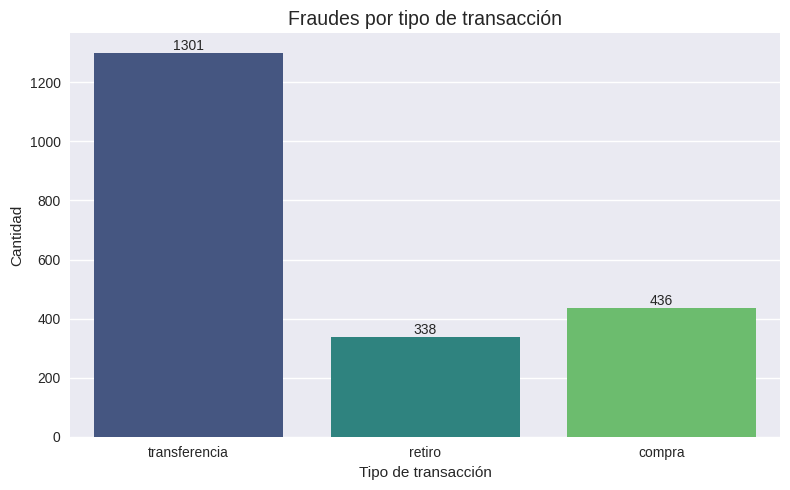

In [12]:
# Filtrar solo las transacciones fraudulentas
fraudes = df[df['es_fraude']]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=fraudes, x='tipo_transaccion', palette='viridis')
plt.title('Fraudes por tipo de transacción', fontsize=14)
plt.xlabel('Tipo de transacción')
plt.ylabel('Cantidad')

# Añadir etiquetas numéricas a las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Visualización: Distribución de fraudes por regla

Gráfico de pastel para mostrar la contribución relativa de cada regla (basado en conteos totales por regla).

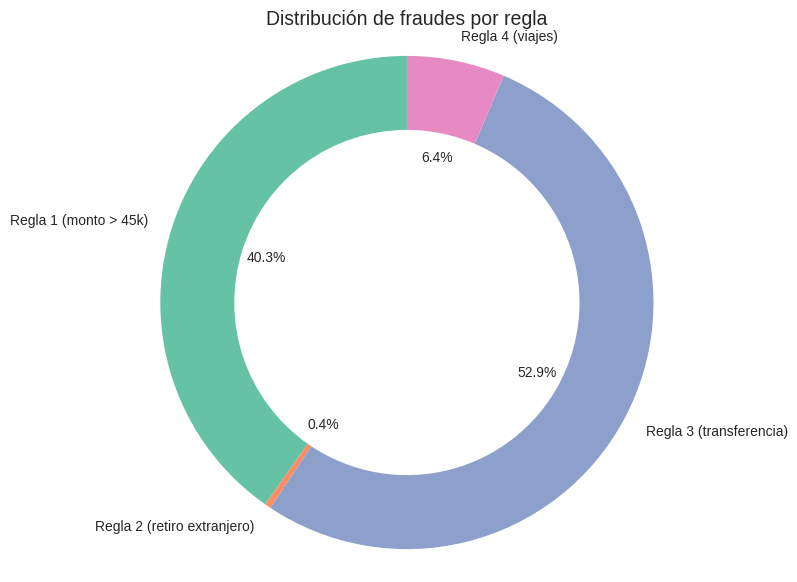

In [13]:
# Conteos por regla
regla_counts = [regla1.sum(), regla2.sum(), regla3.sum(), regla4.sum()]
regla_labels = ['Regla 1 (monto > 45k)', 'Regla 2 (retiro extranjero)',
'Regla 3 (transferencia)', 'Regla 4 (viajes)']

# Gráfico de pastel
plt.figure(figsize=(7, 7))
plt.pie(regla_counts, labels=regla_labels, autopct='%1.1f%%', startangle=90,
wedgeprops=dict(width=0.3), colors=sns.color_palette('Set2'))
plt.title('Distribución de fraudes por regla', fontsize=14)
plt.axis('equal')
plt.show()

## Resultados: Transacciones fraudulentas
Mostramos las primeras y últimas 10 transacciones fraudulentas, junto con estadísticas básicas de los montos

In [14]:
# Mostrar primeras y últimas 10 transacciones fraudulentas
print("Primeras 10 transacciones fraudulentas:")
print(fraudes[['id_transaccion', 'monto', 'tipo_transaccion', 'ciudad', 'categoria_comercio']].head(10))
print("\nÚltimas 10 transacciones fraudulentas:")
print(fraudes[['id_transaccion', 'monto', 'tipo_transaccion', 'ciudad', 'categoria_comercio']].tail(10))

# Estadísticas de montos fraudulentos
print("\nEstadísticas básicas de montos fraudulentos:")
print(fraudes['monto'].describe())

Primeras 10 transacciones fraudulentas:
    id_transaccion     monto tipo_transaccion     ciudad categoria_comercio
0                1  31551.32    transferencia  queretaro                   
2                3  30644.10           retiro      paris                   
8                9  41811.10    transferencia     merida                   
9               10  37271.83    transferencia     puebla                   
11              12  35360.16    transferencia       leon                   
12              13  48471.27    transferencia  monterrey                   
13              14  48485.84           compra  queretaro        restaurante
18              19  49904.69           retiro    torreon                   
20              21  49727.53           retiro    tijuana                   
29              30  39122.25    transferencia  queretaro                   

Últimas 10 transacciones fraudulentas:
      id_transaccion     monto tipo_transaccion       ciudad  \
9945            9946

## Análisis por regla de detección

A continuación, se muestra cuántos fraudes activó cada regla (una transacción puede activar más de una).

In [15]:
# Imprimir conteos totales por regla
print(f"Regla 1 (monto > 45,000): {regla1.sum()}")
print(f"Regla 2 (retiro en extranjero > 25k): {regla2.sum()}")
print(f"Regla 3 (transferencia en extranjero o > 30k): {regla3.sum()}")
print(f"Regla 4 (compra en 'viajes' > 35k): {regla4.sum()}")

Regla 1 (monto > 45,000): 990
Regla 2 (retiro en extranjero > 25k): 10
Regla 3 (transferencia en extranjero o > 30k): 1301
Regla 4 (compra en 'viajes' > 35k): 158


## Conclusiones

- Se detectaron 2,075 transacciones fraudulentas, con la mayoría activadas por la Regla 3 (transferencias > 30k o extranjeras), que contribuyó con 1,301 casos.

- La Regla 3 incluye transferencias desde ciudades extranjeras con montos bajos, lo que genera un alto número de detecciones y potenciales falsos positivos. Se recomienda ajustar el umbral de monto o validar manualmente estos casos.

- La Regla 4 detectó 158 fraudes en la categoría 'viajes' con montos > 35k, corrigiendo la suposición inicial de ausencia de esta categoría.

- El enfoque basado en reglas es efectivo para escenarios predefinidos, pero para grandes volúmenes, se sugiere integrar modelos predictivos (ej. Random Forest) y usar herramientas como Apache Spark para escalabilidad.

- Este análisis refleja comprensión técnica y crítica, con propuestas para mejorar la precisión en la detección de fraudes.